In [1]:
import os
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import pickle
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd 
import polars as pl
import argparse
from collections import Counter
import matplotlib.cm as cm
import seaborn as sns
from numba import jit
import itertools
from cuml.metrics import pairwise_distances
import json
tqdm.pandas()
sns.set_theme()

/home/gwijngaard/miniconda3/envs/audiodata/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import cudf
from cuml.manifold import TSNE
import cupy as cp

embeddings_dir = "/scratch-shared/gwijngaard/embeddings"

def load_embeddings(embeddings_dir, modality):
    """Load all embeddings for a given modality (audio/text)"""
    embeddings_path = os.path.join(embeddings_dir, modality)
    all_embeddings = []
    all_labels = []
    
    # Load allowed datasets if filtering
    allowed_datasets = None
    with open('/gpfs/work4/0/einf6190/audio-datasets/visualization/unique_datasets.json', 'r') as f:
        allowed_datasets = set(json.load(f))
    
    for dataset in os.listdir(embeddings_path):
        # Skip if filtering and dataset not in allowed list
        if dataset not in allowed_datasets:
            continue
            
        dataset_path = os.path.join(embeddings_path, dataset)
        for split_file in os.listdir(dataset_path):
            with open(os.path.join(dataset_path, split_file), 'rb') as f:
                data = pickle.load(f)
                paths, embeds = zip(*data)
                all_embeddings.extend(embeds)
                all_labels.extend([dataset] * len(embeds))
                
    return np.array(all_embeddings), np.array(all_labels)

audio_embeddings, audio_labels = load_embeddings(embeddings_dir, "audio")
text_embeddings, text_labels = load_embeddings(embeddings_dir, "text")

In [3]:
# Remap certain datasets to LAION-Audio-630k
datasets_to_remap = {
    'FreeToUseSounds': 'LAION-Audio-630k',
    'WeSoundEffects': 'LAION-Audio-630k', 
    'Audiostock': 'LAION-Audio-630k',
    'EpidemicSoundEffects': 'LAION-Audio-630k',
    'Paramountall': 'LAION-Audio-630k',
    'macs': 'MACS'
}

# Remap audio labels
for old_name, new_name in datasets_to_remap.items():
    audio_labels[audio_labels == old_name] = new_name
    
# Remap text labels 
for old_name, new_name in datasets_to_remap.items():
    text_labels[text_labels == old_name] = new_name


In [4]:
len(audio_embeddings), len(text_embeddings)

(4496745, 4496745)

In [5]:
# Randomly sample 10% of indices
sample_size = int(len(audio_embeddings) * 0.5)
rng = np.random.RandomState(42)
indices = rng.permutation(len(audio_embeddings))[:sample_size]

# Use indices to sample both embeddings and labels
audio_embeddings = audio_embeddings[indices]
audio_labels = audio_labels[indices]

# Sample text embeddings/labels similarly
sample_size = int(len(text_embeddings) * 0.5)
rng = np.random.RandomState(42)
indices = rng.permutation(len(text_embeddings))[:sample_size]
text_embeddings = text_embeddings[indices]
text_labels = text_labels[indices]


In [6]:
len(audio_embeddings), len(text_embeddings)

(2248372, 2248372)

In [15]:
def get_embeddings(embeddings, perplexity, n_iter):
    print("Converting embeddings to GPU...")
    n_samples = len(embeddings)
    
    # # Reduce dimensionality first using CPU-based PCA to 50 dimensions
    # print("Reducing dimensions with PCA first...")
    # from sklearn.decomposition import PCA
    # pca = PCA(n_components=50)
    # embeddings_pca = pca.fit_transform(embeddings)
    
    # # Convert to GPU for TSNE
    # embeddings_gpu = cp.asarray(embeddings_pca)
    
    reducer = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=42,
        n_neighbors=3*perplexity,
        init='random',  
        n_iter=n_iter, 
        method='fft',
        verbose=True
    )
            
    reduced_embeddings = reducer.fit_transform(embeddings)
    
     
    return reduced_embeddings

In [8]:
def average_distance_to_centroid(group):
    # Convert numpy array to cupy array
    group_gpu = cp.asarray(group)
    centroid = cp.mean(group_gpu, axis=0)
    distances = cp.linalg.norm(group_gpu - centroid, axis=1)
    return cp.mean(distances).get(), centroid.get()

In [9]:
print("Getting embeddings...")
reduced_embeddings_gpu = get_embeddings(audio_embeddings)
# Convert back to CPU for plotting
reduced_embeddings_cpu = cp.asnumpy(reduced_embeddings_gpu)

Getting embeddings...
Converting embeddings to GPU...


/home/gwijngaard/miniconda3/envs/audiodata/lib/python3.12/site-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[D] [13:17:55.191454] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:82 Data size = (2248372, 512) with dim = 2 perplexity = 50.000000
[W] [13:17:55.191521] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
[D] [13:17:55.197733] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:192 Getting distances.
[D] [13:20:22.356463] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:227 Now normalizing distances so exp(D) doesn't explode.
[D] [13:20:22.357993] /opt/conda/conda-bld/work/cpp/src/tsne/tsne_runner.cuh:235 Searching for optimal perplexity via bisection search.
[D] [13:20:53.366896] /opt/conda/conda-bld/work/python/cuml/build/cp312-cp312-linux_x86_64/cuml/internals/logger.cxx:5269 [t-SNE] KL divergence: 0.0


In [10]:
colors = [
    '#ffcc80',  # orange!20
    '#e0b2e5',  # purple!20
    '#b3d9ff',  # blue!20 
    '#b2d8d8',  # teal!20
    '#c1e6b3',  # green!20
    '#b3e6e6',  # cyan!20
    '#ffb3b3',  # red!20
    '#ffe6b3',  # yellow!20
    '#ffb3ff',  # magenta!20
    '#b3ffb3',  # lime!20
    '#e6ccb3',  # brown!20
    '#ccb3e6',  # violet!20
    '#b3e6cc',  # emerald!20
    '#e6b3b3',  # pink!20
    '#b3cce6',  # lightblue!20
    '#e6e6b3',  # olive!20
    '#ccb3cc',  # plum!20
    '#b3e6d9',  # turquoise!20
    '#e6bfb3',  # peach!20
    '#b3ccd9',  # skyblue!20
    '#ffcc80',  # orange!20
    '#e0b2e5',  # purple!20
    '#b3d9ff',  # blue!20
    '#b2d8d8'   # teal!20
]

Creating plot layout...
Plotting points...


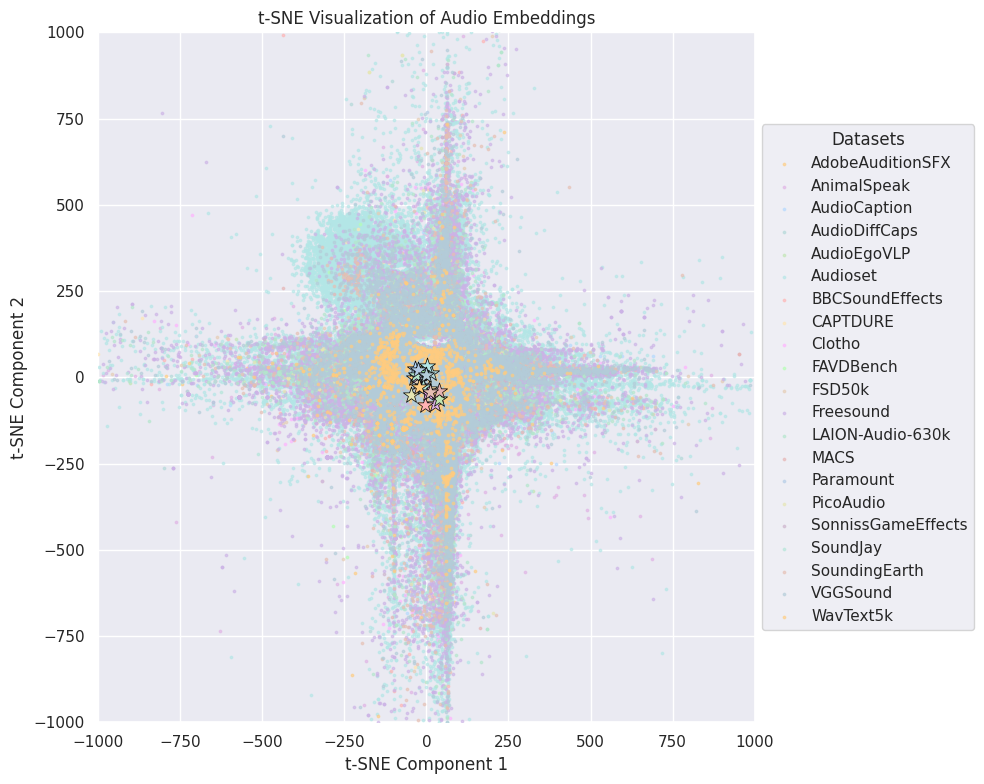

In [14]:
# Create plot
print("Creating plot layout...")
fig, ax = plt.subplots(figsize=(10, 8))

# Create mapping for any additional labels
all_labels = np.unique(np.concatenate([audio_labels, text_labels]))
color_mapping = {label: colors[i % len(colors)] for i, label in enumerate(all_labels)}

# Plot points for each dataset
print("Plotting points...")
for idx, label in enumerate(all_labels):
    mask = audio_labels == label
    if np.any(mask):

        ax.scatter(reduced_embeddings_cpu[mask, 0], 
                  reduced_embeddings_cpu[mask, 1],
                  c=color_mapping[label],
                  label=label,
                  s=3,
                  alpha=0.6,
                  zorder=idx+3)

# Add centroids with star markers
for label in all_labels:
    variability, centroid = average_distance_to_centroid(reduced_embeddings_gpu[audio_labels == label])
    ax.scatter(centroid[0], 
                centroid[1],
                c=color_mapping[label],
                marker='*',
                s=150,
                edgecolors='black',
                linewidths=0.5,
                zorder=40)
    # ax.annotate(label, 
    #             (centroid[0], centroid[1]),
    #             xytext=(5, 5), 
    #             textcoords='offset points',
    #             fontsize=8,
    #             zorder=41)

# Set labels and title
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2') 
ax.set_title('t-SNE Visualization of Audio Embeddings')

# Set axis limits
ax.set_xlim(-250, 250)
ax.set_ylim(-250, 250)

# Add legend
ax.legend(title="Datasets",
         loc='center left',
         bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()
plt.show()

In [12]:
# # Create plot
# print("Creating plot layout...")
# fig, axs = plt.subplots(1, 1, figsize=(20, 8))


# print("Plotting t-SNE for text embeddings...")
# plot_tsne(text_labels, text_embeddings, "CLAP Text Embeddings t-SNE", axs[0], label_to_color)


# # Add legend
# custom_lines = [plt.Line2D([0], [0], marker='o', color='w',
#                             markerfacecolor=label_to_color[label], markersize=10)
#                 for label in unique_labels]
# fig.legend(custom_lines, unique_labels, title="Datasets",
#             loc='center right', bbox_to_anchor=(1.15, 0.5))

# plt.tight_layout()
# plt.show()